# Part 1 - Calculating the thermal resistance

For Part 1 of the Hands-On Exercise, we will retrieve heat exchanger data from CDF using the Python SDK and use it to calculate the thermal resistance. The steps include the following:

1. Authentication and Client Creation
2. Finding data related to the system
3. Retrieve the data
4. Visualise the data
5. Calculation of the Thermal Resistance


## 1. Authentication and Client Creation

Here we'll create the cognite client using Client credentials. We need to supply the tenant_id, client_id and client secret along with cluster name and project name to create the cognite client. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the cognite data platform (CDF)

In [7]:
from cognite.client import CogniteClient
from msal import PublicClientApplication
#from cognite.experimental import CogniteClient


# Contact Project Administrator to get these
TENANT_ID="48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID="fab52bb5-9de2-4f9e-aefa-712da4b5fe00"
CDF_CLUSTER="westeurope-1"
COGNITE_PROJECT="ds-basics"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000

app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)
creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)

TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"

client = CogniteClient(
    token_url=creds["id_token_claims"]["iss"],
    token=creds["access_token"],
    token_client_id=creds["id_token_claims"]["aud"],
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cognite-client-interactive"
    )

Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)
/home/keepfloyding/.local/lib/python3.10/site-packages/cognite/client/_cognite_client.py:84: UserWarning: You are using version 2.55.0 of the SDK, however version 2.56.1 is available. Upgrade or set the environment variable 'COGNITE_DISABLE_PYPI_VERSION_CHECK' to suppress this warning.
  self._config = ClientConfig(


This is just one of the ways to create the client, there are many other ways e.g. Interactive login, Device code etc
Guide for authentication and creating the client is available here https://github.com/cognitedata/python-oidc-authentication

## 2. Finding data related to the System

This can be achieved with the Hierarchy based structure in the CDF. High level System are stored as the Assets e.g. here **23-HA-9114** and **23-HA-9115** are stored as the assets. All the tags related to them are linked to the respective assets in order to access them easily.

Let's quickly get the IDs for assets we're interested in

In [8]:
asset_name = "23-HA-9114"
assets = client.assets.search(name=asset_name)
assets[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,source,id,created_time,last_updated_time,root_id
0,5345363121325760,23-HA-9114,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,7640884189698369,1652690345913,1652690345913,2075231145010555
1,1305599545806638,23-HA-9115,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 2,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,2096576847847256,1652690345913,1652690345913,2075231145010555
2,8820916275841408,23-VA-9114,6990494653502625,2499711953216311,VRD - 1ST STAGE COMPRESSOR MARINE VANE SEPARATOR,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,8140508315193333,1652690345913,1652690345913,2075231145010555
3,1308676097270399,23-GO-9114,6990494653502625,2499711953216311,VRD - 1ST STAGE COMPPRESSOR ENCLOSURE INLET AI...,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,7778925754685498,1652690345913,1652690345913,2075231145010555
4,2861239574637735,23-HA-9103,264396548249584,2513266419866445,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",petro-tech-staging,7130743143880734,1652690345913,1652690345913,2075231145010555


Now we can use the first two IDs to get the time series or any other data related to these two Heat Exchangers/Discharge coolers **23-HA-9114** and **23-HA-9115**

In [9]:
client.time_series.list(asset_subtree_ids=[7640884189698369,2096576847847256])[:5]

,id,external_id,name,is_string,metadata,asset_id,is_step,description,security_categories,created_time,last_updated_time,unit
0,328127348154751,pi:160037,VAL_23_FIC_92543_08:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH 1stStgComp AntSrg Limit 2 PV,[],1652691565833,1652691565833,NaN
1,385469970857424,pi:191092,VAL_23-TT-92604A:X.Value,False,"{'engunits': 'degC', 'span': '100', 'instrumen...",7472153895477615,False,PH 1stStgDiscCool Gas Out Output,[],1652691565833,1652691565833,degC
2,524525133603395,pi:160039,VAL_23_FIC_92543_11:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH Surge Counter,[],1652691566033,1652691566033,NaN
3,963605533237469,pi:160888,VAL_23-TT-92603:X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",4307262662732694,False,PH 1stStgDiscCool Gas Out,[],1652691565806,1652691565806,NaN
4,1336520588941003,pi:160034,VAL_23_FIC_92543_05:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH 1stStgComp First AntSrg CountTot,[],1652691566102,1652691566102,NaN


You can also retrieve the subtree for these Assets

In [10]:
subtree = client.assets.retrieve_subtree(id=7640884189698369)
subtree[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,source,id,created_time,last_updated_time,root_id
0,5345363121325760,23-HA-9114,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,7640884189698369,1652690345913,1652690345913,2075231145010555
1,6045313781173559,23-FV-92543,7640884189698369,5345363121325760,VRD - PH 1STSTGCOMP ANTI-SURGE,"{'ELC_STATUS_ID': '1211', 'RES_ID': '569425', ...",petro-tech-staging,534249684184196,1652690345913,1652690345913,2075231145010555
2,3214951100107740,45-TT-92606,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCCLR COOLMED SPLY,"{'ELC_STATUS_ID': '1211', 'RES_ID': '496518', ...",petro-tech-staging,791972270586176,1652690345913,1652690345913,2075231145010555
3,5901066000673985,23-ESDV-92551B,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCHCLR GAS OUT EQ,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,1427443677325668,1652690345913,1652690345913,2075231145010555
4,5412677358344403,23-TV-92604B,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCCOOL COOLMED IN,"{'ELC_STATUS_ID': '1211', 'RES_ID': '609904', ...",petro-tech-staging,2179606378425112,1652690345913,1652690345913,2075231145010555


There are many filtering and searching options in python sdk. refer to the documentation for more details.

## 3. Retrieve the Data

Let's Fetch the Temperatures and Flow rates for the discharge coolers.
We can look up external IDs for the sensors we're interested in and use them to filter & retrieve the data we need from CDF.

Specify the start and end date , there are also options for aggregation and granularity of data.
Note : Instead of dates, we can also specify strings for start and end dates, e.g. **start="2w-ago", end="now"**



In [11]:
column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']

import datetime
from datetime import timedelta
start_date = datetime.datetime(2018, 8, 1)
end_date = start_date + timedelta(days=30)

df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                     aggregates=['average'],
                                                     granularity='1h',
                                                     start=start_date,
                                                     end=end_date,
                                                     include_aggregate_name=False
                                                     )
df.fillna(method="ffill", inplace=True)
df.columns = column_names
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,101.142261,164362.175208
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,99.901727,163875.622135
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,100.574942,164397.399993
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,99.346718,163128.807848
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,99.440407,163634.013288


## 4. Visualize the data

Let's quickly plot the data

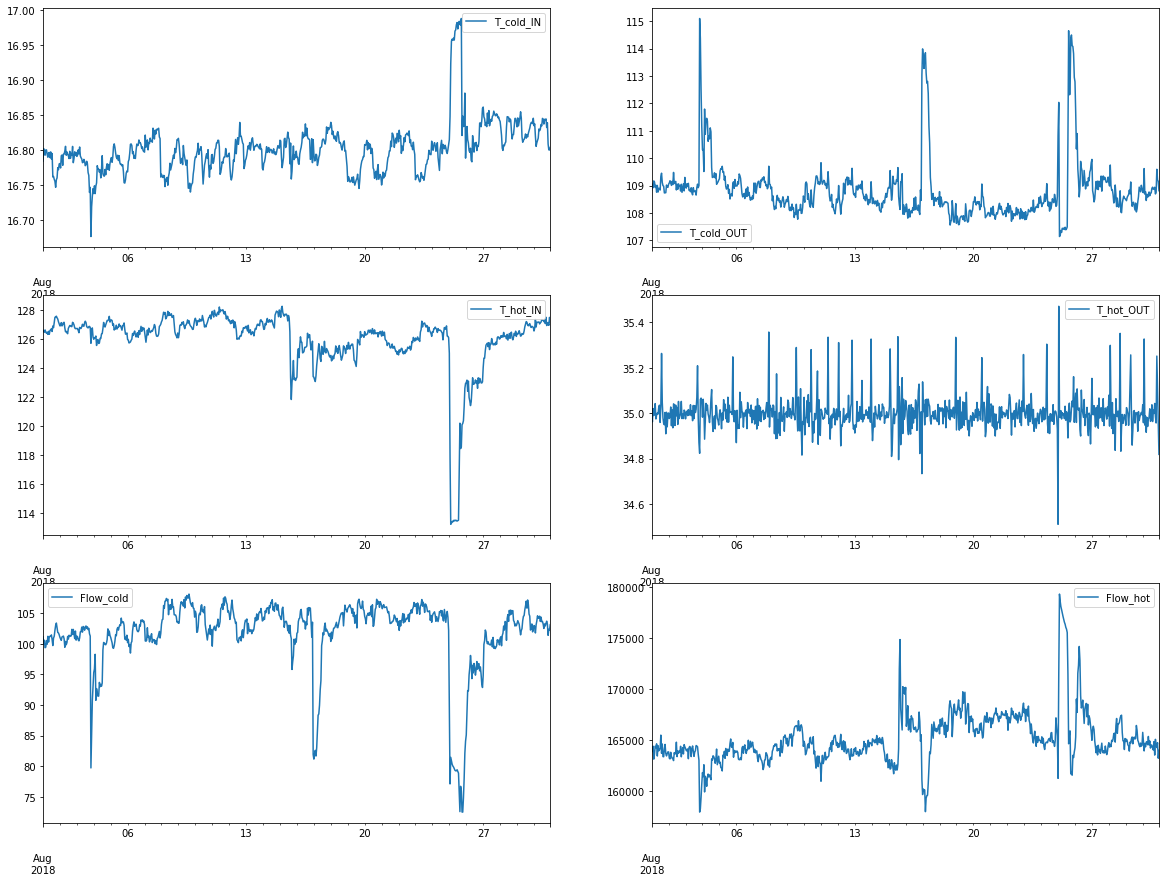

In [12]:
import matplotlib.pyplot as plt
cols = df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for i, col in enumerate(cols):
    df.loc[:, [col]].plot(ax=axes.ravel()[i])

## 5. Heat Exchanger Calculations
First of all let's bring the mass flow rates into same unit of measurement. (kg/seconds)

In [14]:
df['Flow_cold'] = df['Flow_cold']*1000/3600.0
df['Flow_hot'] = df['Flow_hot']/3600.0
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,7.804187,0.012682
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,7.708467,0.012645
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,7.760412,0.012685
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,7.665642,0.012587
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,7.672871,0.012626


Let's create the function for Thermal Resistance Calculation `TR = A * F * LMTD/Q`

where A=Area, F= Correction Factor, LMTD - Log Mean Temperature Difference,
Q - Heat Transfer Rate

`LMTD = ((T_hot_IN-T_cold_OUT)-(T_hot_OUT-T_cold_IN))/(log((T_hot_IN-T_cold_OUT)/(T_hot_OUT-T_cold_IN)))`

`Q = Flow_hot * Cp_hot *(T_hot_IN-T_hot_OUT)`

Let's implement these formulas in a function

In [16]:
from math import log
def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = abs(x['T_hot_IN'] - x['T_cold_OUT'])
    x['dT2'] = abs(x['T_hot_OUT'] - x['T_cold_IN'])
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    TR = temp1/temp2
    return TR

df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot,TR
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,7.804187,0.012682,5.164023
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,7.708467,0.012645,5.127132
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,7.760412,0.012685,5.138101
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,7.665642,0.012587,5.150379
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,7.672871,0.012626,5.127618


Now this calculation result is only available in this notebook, and each time  we need the value of Thermal Resitance, we'll have to fecth the data and run the above code manually. In the case, we want to presist the result of this calculation, we need to save this in CDF.

Cognite functions can be a solution for this type of calculation and saving results in CDF to be accessible later use or in other applications. 